In [12]:
from astropy.table import Table

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, skewnorm
from scipy.optimize import curve_fit, minimize
from scipy.special import gammaln

import dynesty
from dynesty import plotting as dyplot

#from skewNorms_fit import skewNorms3_fit, skewNorms3

## Import data

In [3]:
#galaxy_filename = '/Users/kellydouglass/Documents/Drexel/Research/Data/kias1033_5_P-MJD-F_MPAJHU_ZdustOS_stellarMass_BPT_SFR_NSA_correctVflag.txt'
galaxy_filename = '/Users/kellydouglass/Documents/Research/data/kias1033_5_P-MJD-F_MPAJHU_ZdustOS_HI100_NSAv101_CMDJun2020.txt'

galaxies = Table.read(galaxy_filename, format='ascii.commented_header')

## Plot color histograms

<IPython.core.display.Javascript object>


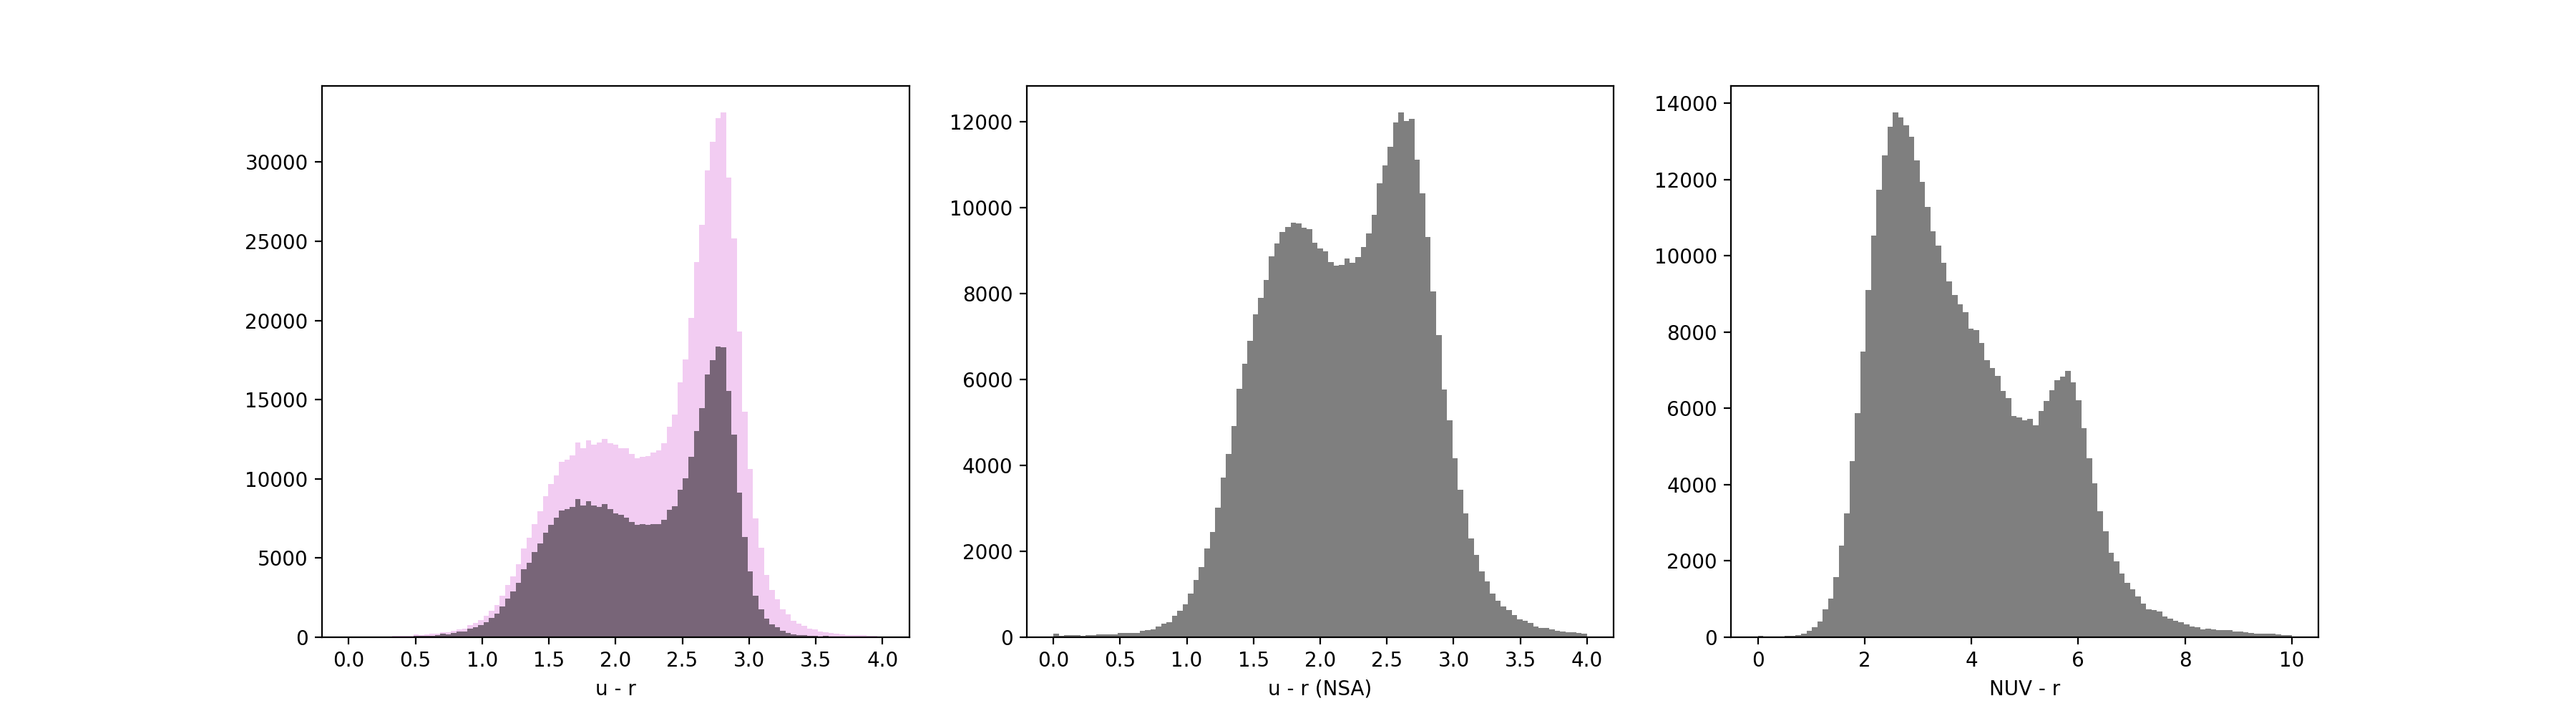

In [4]:
%matplotlib notebook

# Remove NaN values
galaxies_NSA = galaxies[np.isfinite(galaxies['NUV_r'])]

x_range = np.linspace(0, 10, 100)
ur_bins = np.linspace(0, 4, 100)

plt.figure(figsize=(18,5))

plt.subplot(131)
plt.hist(galaxies['u_r'], bins=ur_bins, alpha=0.2, facecolor='m')
ur_n,_,_ = plt.hist(galaxies_NSA['u_r'], bins=ur_bins, alpha=0.5, facecolor='k')
plt.xlabel('u - r')

plt.subplot(132)
urNSA_n,_,_ = plt.hist(galaxies_NSA['u_r_NSA'], bins=ur_bins, alpha=0.5, facecolor='k')
plt.xlabel('u - r (NSA)')

plt.subplot(133)
n,_,_ = plt.hist(galaxies_NSA['NUV_r'], bins=x_range, alpha=0.5, facecolor='k')
plt.xlabel('NUV - r');

Actually, the reduction in sample size for galaxies in the NSA is not as skewed away from the red sequence as I had imagined.

# Gaussian mixture model
Fit a sum of 3 (or 4) Gaussians to the color histograms

In [16]:
def tri_norm(args, x):
    m1, m2, m3, s1, s2, s3, k1, k2, k3 = args
    ret = k1*norm.pdf(x, loc=m1, scale=s1)
    ret += k2*norm.pdf(x, loc=m2, scale=s2)
    ret += k3*norm.pdf(x, loc=m3, scale=s3)
    return ret


def quad_norm(args, x):
    m1, m2, m3, m4, s1, s2, s3, s4, k1, k2, k3, k4 = args
    ret = k1*norm.pdf(x, loc=m1, scale=s1)
    ret += k2*norm.pdf(x, loc=m2, scale=s2)
    ret += k3*norm.pdf(x, loc=m3, scale=s3)
    ret += k4*norm.pdf(x, loc=m4, scale=s4)
    return ret

In [17]:
def logL_triNorm(params, n, x):
    lambda1 = tri_norm(params, x)
    lambda1[lambda1 <= 0] = np.finfo(dtype=np.float64).tiny
    return np.sum(n*np.log(lambda1) - lambda1 - gammaln(n + 1))


def logL_quadNorm(params, n, x):
    lambda1 = quad_norm(params, x)
    lambda1[lambda1 <= 0] = np.finfo(dtype=np.float64).tiny
    return np.sum(n*np.log(lambda1) - lambda1 - gammaln(n + 1))



def nlogL_triNorm(params, n, x):
    return -logL_triNorm(params, n, x)


def nlogL_quadNorm(params, n, x):
    return -logL_quadNorm(params, n, x)

In [40]:
def leastSquares_triNorm(params, n, x):
    lambda1 = tri_norm(params, x)
    return np.sum((n - lambda1)*(n - lambda1))


def leastSquares_quadNorm(params, n, x):
    lambda1 = quad_norm(params, x)
    return np.sum((n - lambda1)*(n - lambda1))



def logLeastSquares_triNorm(params, n, x):
    return np.log(leastSquares_triNorm(params, n, x))


def logLeastSquares_quadNorm(params, n, x):
    return np.log(leastSquares_quadNorm(params, n, x))

In [25]:
NUVr_bounds3 = [[1, 3],        # Blue cloud mean
                [3, 5],        # Green valley mean
                [5, 10],       # Red sequence mean
                [0, 1],        # Blue cloud width
                [0, 1],        # Green valley width
                [0, 2],        # Red sequence width
                [1000, 100000], # Blue cloud amplitude
                [1000, 100000], # Green valley amplitude
                [1000, 100000]  # Red sequence amplitude
               ]

'''
NUVr_p0_3 = [3, 4, 5, 1, 1, 1, 1, 1, 1]

NUVr_bestfit3 = minimize(nlogL_triNorm, NUVr_p0_3, args=(n, x_range[:-1]), bounds=NUVr_bounds3)
'''
NUVr_bestfit3 = None

for i in range(30):
    p0 = [np.random.uniform(b[0], b[1]) for b in NUVr_bounds3]
    #result = minimize(nlogL_triNorm, p0, method='L-BFGS-B', args=(n, x_range[:-1]), bounds=NUVr_bounds3)
    result = minimize(leastSquares_triNorm, p0, method='L-BFGS-B', args=(n, x_range[:-1]), bounds=NUVr_bounds3)
    
    if result.success:
        if NUVr_bestfit3 is None:
            NUVr_bestfit3 = result
        elif result.fun < NUVr_bestfit3.fun:
            NUVr_bestfit3 = result

print(NUVr_bestfit3)

      fun: 20222428.695351116
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1057.2373867 ,  2103.29890251,  -652.29833126, 14895.94578743,
       -6562.47138977, -1358.61337185,  1758.33702087,  1914.05415535,
        3308.80284309])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 810
      nit: 43
   status: 0
  success: True
        x: array([2.32872731e+00, 3.11240475e+00, 5.06519531e+00, 4.66809154e-01,
       6.70369165e-01, 1.22404570e+00, 9.92989607e+03, 1.28473229e+04,
       2.04577223e+04])


In [27]:
NUVr_bounds4 = [[1, 3],        # Blue cloud mean
                [3, 5],        # Green valley mean
                [4, 10],       # Red sequence1 mean
                [5, 10],       # Red sequence2 mean
                [0, 1],        # Blue cloud width
                [0, 1],        # Green valley width
                [0, 2],        # Red sequence1 width
                [0, 2],        # Red sequence2 width
                [1000, 100000], # Blue cloud amplitude
                [1000, 100000], # Green valley amplitude
                [1000, 100000], # Red sequence1 amplitude
                [1000, 100000]  # Red sequence2 amplitude
               ]

'''
NUVr_p0_4 = [3, 4, 5, 6, 1, 1, 1, 1, 1, 1, 1, 1]

NUVr_bestfit4 = minimize(nlogL_quadNorm, NUVr_p0_4, args=(n, x_range[:-1]), bounds=NUVr_bounds4)
'''
NUVr_bestfit4 = None

for i in range(30):
    p0 = [np.random.uniform(b[0], b[1]) for b in NUVr_bounds4]
    #result = minimize(nlogL_quadNorm, p0, method='L-BFGS-B', args=(n, x_range[:-1]), bounds=NUVr_bounds4)
    result = minimize(leastSquares_quadNorm, p0, method='L-BFGS-B', args=(n, x_range[:-1]), bounds=NUVr_bounds4)
    
    if result.success:
        if NUVr_bestfit4 is None:
            NUVr_bestfit4 = result
        elif result.fun < NUVr_bestfit4.fun:
            NUVr_bestfit4 = result

print(NUVr_bestfit4)

      fun: 2168410.3073167615
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.41942786e+03, -3.46801244e+03,  3.26195732e+02,  1.75484963e+07,
        6.44102693e+02,  4.78699803e+01, -2.30469741e+03,  6.18491322e+02,
       -1.62040815e+03, -1.94543973e+03,  1.92713924e+03, -1.60001218e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 715
      nit: 48
   status: 0
  success: True
        x: array([2.51122636e+00, 3.72145749e+00, 5.75918180e+00, 5.00000000e+00,
       5.48460932e-01, 5.82743673e-01, 3.98109501e-01, 1.24127583e+00,
       1.72191887e+04, 7.24189928e+03, 3.08181995e+03, 1.44255403e+04])


In [19]:
ur_params = [1.75, 2.25, 2.75, 1, 1, 1, 1, 1, 1]
ur_low_bounds = [0.5, 1.75, 2.5, -np.inf, -np.inf, -np.inf, 0, 0, 0]
ur_high_bounds = [2, 2.5, 3.5, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]

ur_fitted_params,_ = curve_fit(tri_norm, 
                               x_range[:-1], 
                               ur_n, 
                               p0=ur_params, 
                               bounds=(ur_low_bounds, ur_high_bounds))

print(ur_fitted_params)

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [16]:
urNSA_params = [1.75, 2.25, 2.75, 1, 1, 1, 1, 1, 1]

urNSA_fitted_params,_ = curve_fit(tri_norm, x_range[:-1], urNSA_n, p0=urNSA_params)

print(urNSA_fitted_params)

[6.62261061e+00 5.64954539e+00 4.05399977e+00 4.82673052e-01
 1.28820692e+00 7.45267117e-01 7.68955215e+03 2.40445127e+04
 1.02331741e+04]


## Plot color histograms with fit

<IPython.core.display.Javascript object>


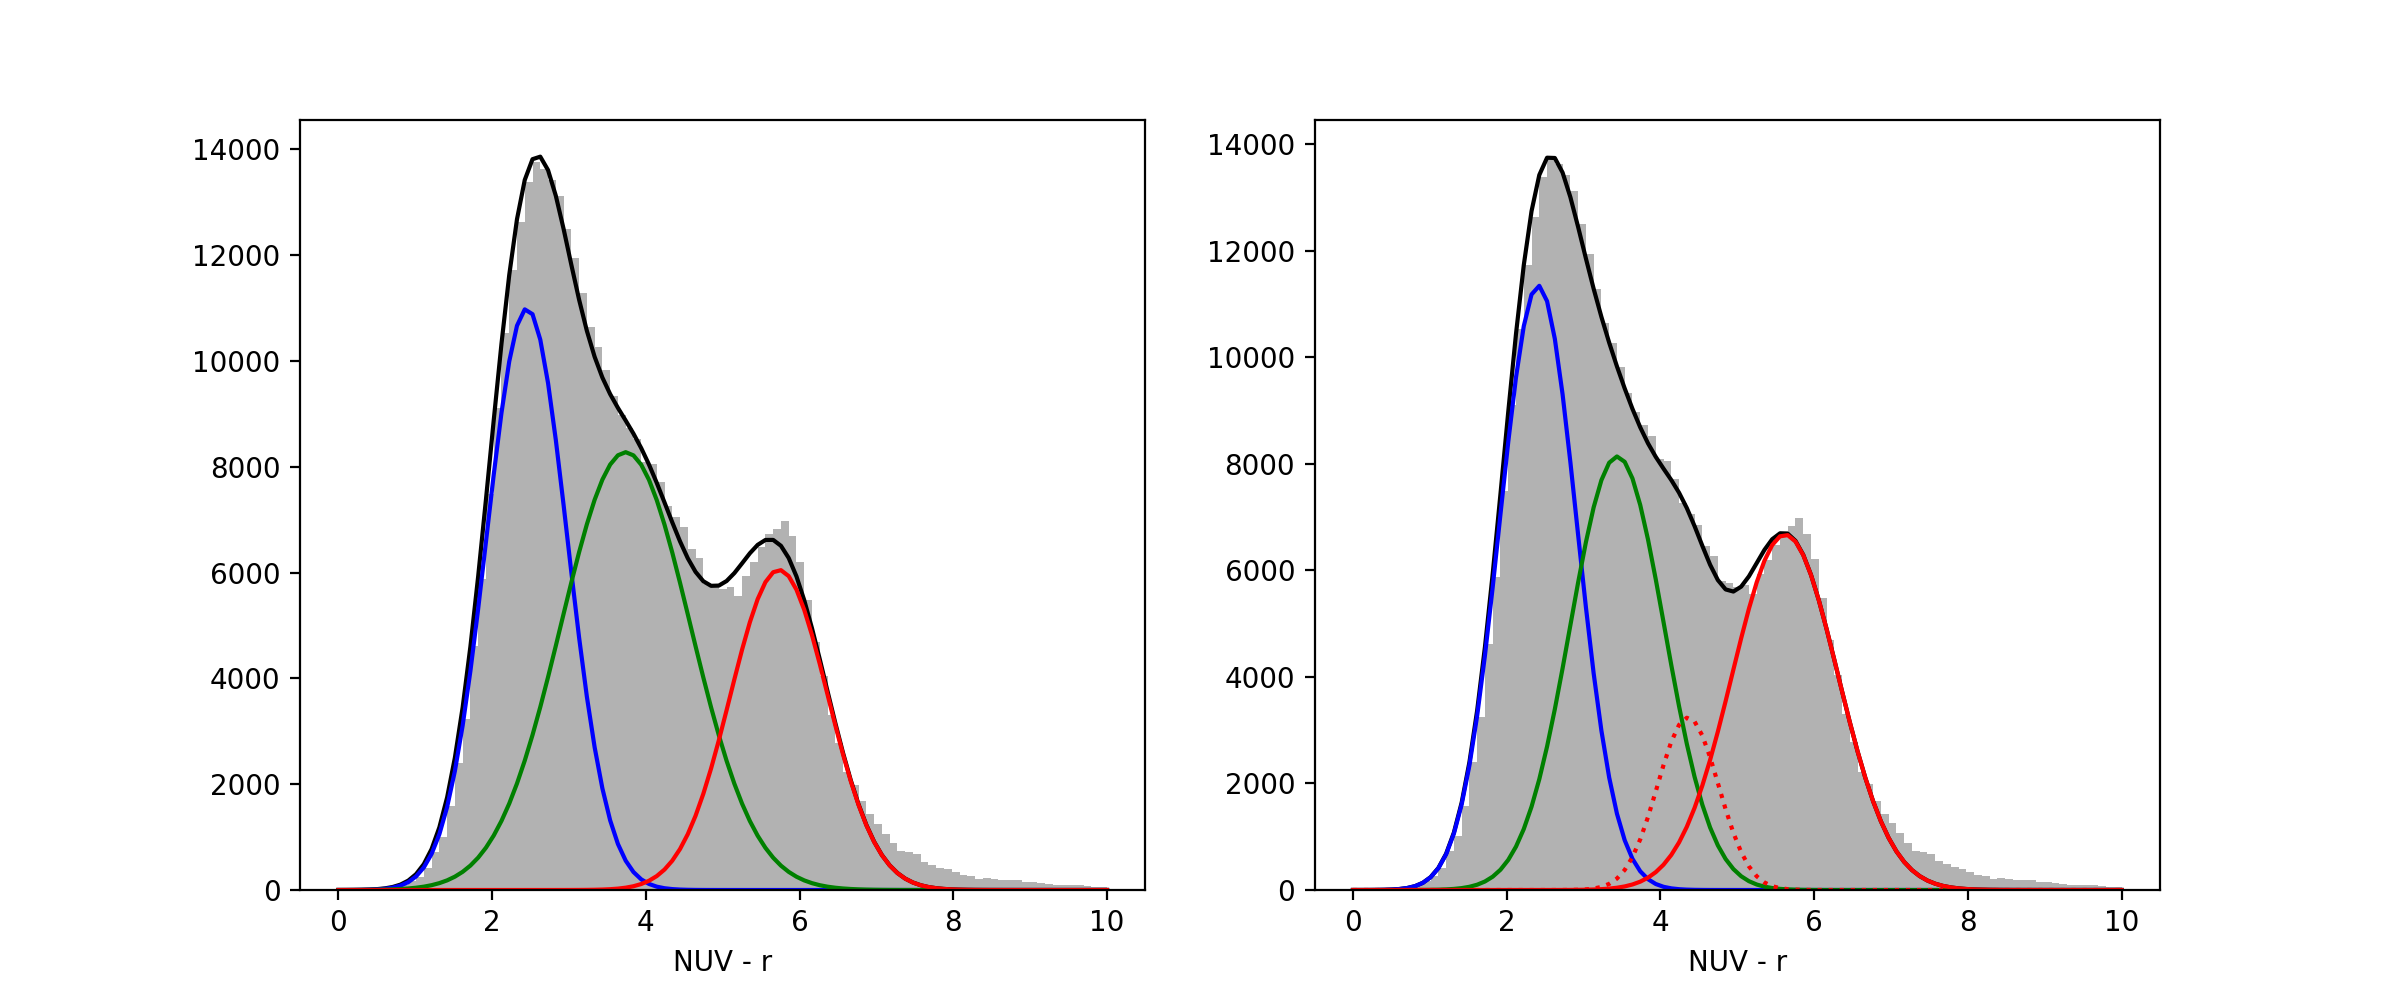

In [11]:
%matplotlib notebook


plt.figure(figsize=(12,5))


'''
plt.subplot(131)

plt.hist(galaxies_NSA['u_r'], bins=ur_bins, alpha=0.3, facecolor='k')

plt.plot(ur_bins, tri_norm(ur_bins, *ur_fitted_params), 'k')
plt.plot(ur_bins, ur_fitted_params[6]*norm.pdf(ur_bins, loc=ur_fitted_params[0], scale=ur_fitted_params[3]), 'b')
plt.plot(ur_bins, ur_fitted_params[7]*norm.pdf(ur_bins, loc=ur_fitted_params[1], scale=ur_fitted_params[4]), 'g')
plt.plot(ur_bins, ur_fitted_params[8]*norm.pdf(ur_bins, loc=ur_fitted_params[2], scale=ur_fitted_params[5]), 'r')

plt.xlabel('u - r')



plt.subplot(132)

plt.hist(galaxies_NSA['u_r_NSA'], bins=ur_bins, alpha=0.3, facecolor='k')

plt.plot(ur_bins, tri_norm(ur_bins, *urNSA_fitted_params), 'k')
plt.plot(ur_bins, 
         urNSA_fitted_params[6]*norm.pdf(ur_bins, 
                                         loc=urNSA_fitted_params[0], 
                                         scale=urNSA_fitted_params[3]), 
         'b')
plt.plot(ur_bins, 
         urNSA_fitted_params[7]*norm.pdf(ur_bins, 
                                         loc=urNSA_fitted_params[1], 
                                         scale=urNSA_fitted_params[4]), 
         'g')
plt.plot(ur_bins, 
         urNSA_fitted_params[8]*norm.pdf(ur_bins, 
                                         loc=urNSA_fitted_params[2], 
                                         scale=urNSA_fitted_params[5]), 
         'r')

plt.xlabel('u - r (NSA)')
'''



plt.subplot(121)

plt.hist(galaxies_NSA['NUV_r'], bins=x_range, alpha=0.3, facecolor='k')

plt.plot(x_range, tri_norm(x_range, *NUVr_fitted_params3), 'k')
plt.plot(x_range, 
         NUVr_fitted_params3[6]*norm.pdf(x_range, 
                                         loc=NUVr_fitted_params3[0], 
                                         scale=NUVr_fitted_params3[3]), 
         'b')
plt.plot(x_range, 
         NUVr_fitted_params3[7]*norm.pdf(x_range, 
                                         loc=NUVr_fitted_params3[1], 
                                         scale=NUVr_fitted_params3[4]), 
         'g')
plt.plot(x_range, 
         NUVr_fitted_params3[8]*norm.pdf(x_range, 
                                         loc=NUVr_fitted_params3[2], 
                                         scale=NUVr_fitted_params3[5]), 
         'r')

plt.xlabel('NUV - r')



plt.subplot(122)

plt.hist(galaxies_NSA['NUV_r'], bins=x_range, alpha=0.3, facecolor='k')

plt.plot(x_range, quad_norm(x_range, *NUVr_fitted_params4), 'k')
plt.plot(x_range, 
         NUVr_fitted_params4[8]*norm.pdf(x_range, 
                                         loc=NUVr_fitted_params4[0], 
                                         scale=NUVr_fitted_params4[4]), 
         'b')
plt.plot(x_range, 
         NUVr_fitted_params4[9]*norm.pdf(x_range, 
                                         loc=NUVr_fitted_params4[1], 
                                         scale=NUVr_fitted_params4[5]), 
         'g')
plt.plot(x_range, 
         NUVr_fitted_params4[10]*norm.pdf(x_range, 
                                          loc=NUVr_fitted_params4[2], 
                                          scale=NUVr_fitted_params4[6]), 
         ':r')
plt.plot(x_range, 
         NUVr_fitted_params4[11]*norm.pdf(x_range, 
                                          loc=NUVr_fitted_params4[3], 
                                          scale=NUVr_fitted_params4[7]), 
         'r')

plt.xlabel('NUV - r');

### Nested sampling of the Likelihood and Priors

In [28]:
def uniform(a, b, u):
    return a + (b - a)*u


def jeffreys(a, b, u):
    return a**(1 - u) * b**u

In [34]:
def prior_xTrio(u):
    m1 = uniform(1, 3, u[0])
    m2 = uniform(3, 5, u[1])
    m3 = uniform(5, 10, u[2])
    s1 = jeffreys(0.001, 1, u[3])
    s2 = jeffreys(0.001, 1, u[4])
    s3 = jeffreys(0.001, 2, u[5])
    k1 = jeffreys(1000, 100000, u[6])
    k2 = jeffreys(1000, 100000, u[7])
    k3 = jeffreys(1000, 100000, u[8])
    
    return m1, m2, m3, s1, s2, s3, k1, k2, k3


def prior_xQuad(u):
    m1 = uniform(1, 3, u[0])
    m2 = uniform(3, 5, u[1])
    m3 = uniform(4, 10, u[2])
    m4 = uniform(5, 10, u[3])
    s1 = jeffreys(0.001, 1, u[4])
    s2 = jeffreys(0.001, 1, u[5])
    s3 = jeffreys(0.001, 2, u[6])
    s4 = jeffreys(0.001, 2, u[7])
    k1 = jeffreys(1000, 100000, u[8])
    k2 = jeffreys(1000, 100000, u[9])
    k3 = jeffreys(1000, 100000, u[10])
    k4 = jeffreys(1000, 100000, u[11])
    
    return m1, m2, m3, m4, s1, s2, s3, s4, k1, k2, k3, k4

In [41]:
dsampler3 = dynesty.DynamicNestedSampler(logLeastSquares_triNorm, prior_xTrio, ndim=9, 
                                         logl_args=(n, x_range[:-1]), 
                                         nlive=1000, 
                                         bound='multi', 
                                         sample='auto')

dsampler3.run_nested()
dres1_3 = dsampler3.results

5862it [5:02:37,  3.10s/it, batch: 0 | bound: 2047 | nc: 5990 | ncall: 1818064 | eff(%):  0.322 | loglstar:   -inf < 34.669 <    inf | logz: 27.813 +/-  0.122 | dlogz:  0.010 >  0.010]  


KeyboardInterrupt: 

# Skew normal mixture model

Fit the NUV-r distribution with the sum of three skew normal distributions.

In [8]:
param_bounds = [[10., 20000.], # a ........ skew normal 1 amplitude
                [1.0, 3.5],    # mu_a ..... skew normal 1 mean
                [0.01, 3.0],   # sigma_a .. skew normal 1 standard deviation
                [-30., 30.],   # skew_a ... skew normal 1 skew
                [1., 20000.],  # b ........ skew normal 2 amplitude
                [3.0, 5.5],    # mu_b ..... skew normal 2 mean
                [0.01, 3.0],   # sigma_b .. skew normal 2 standard deviation
                [-20., 20.],   # skew_b ... skew normal 2 skew
                [1., 10000.],  # c ........ skew normal 3 amplitude
                [5.0, 8.0],    # mu_c ..... skew normal 3 mean
                [0.01, 3.0],   # sigma_c .. skew normal 3 standard deviation
                [-20., 20.]    # skew_c ... skew normal 3 skew
               ]

bestfit = skewNorms3_fit(x_range[:-1], n, param_bounds)

print(bestfit)

      fun: 859.0283654678389
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.07371455,  1.03580078,  0.22089353,  0.04970389, -0.07945573,
       -0.03913101, -0.55318878,  0.15769501, -0.07003109,  0.16748345,
       -0.29087914, -0.05095444])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 5070
      nit: 304
   status: 0
  success: True
        x: array([ 1.92574986e+04,  1.92789054e+00,  1.13807487e+00,  2.87925467e+00,
        1.85919025e+04,  3.05932448e+00,  2.04377584e+00,  1.83142000e+00,
        4.02465003e+03,  6.11158757e+00,  5.79241899e-01, -1.37849123e+00])


<IPython.core.display.Javascript object>


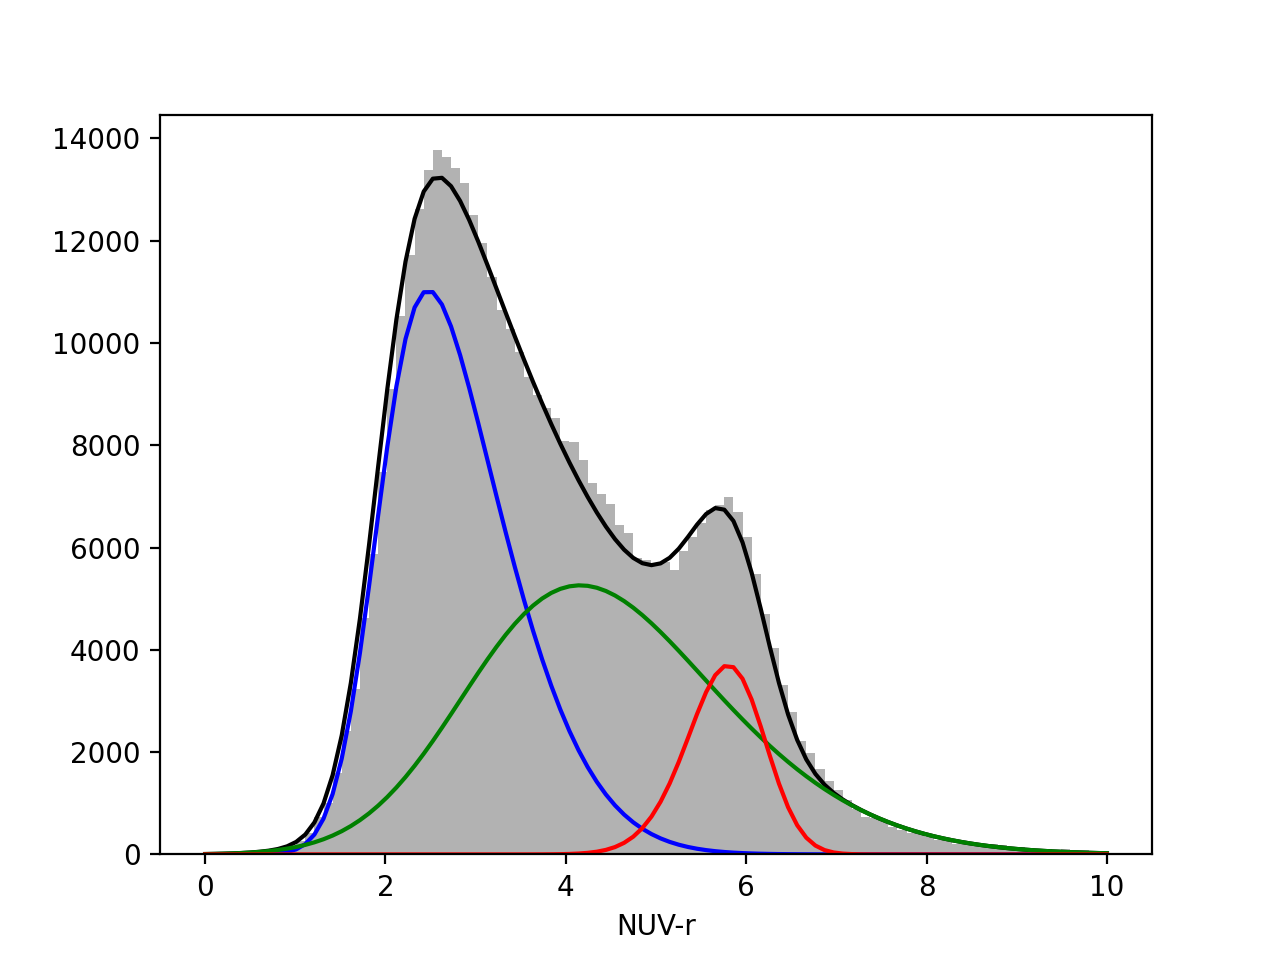

In [9]:
%matplotlib notebook

plt.figure()

plt.hist(galaxies_NSA['NUV_r'], bins=x_range, alpha=0.3, facecolor='k')

plt.plot(x_range, skewNorms3(bestfit.x, x_range), 'k')
plt.plot(x_range, bestfit.x[0]*skewnorm.pdf(x_range, bestfit.x[3], loc=bestfit.x[1], scale=bestfit.x[2]), 'b')
plt.plot(x_range, bestfit.x[4]*skewnorm.pdf(x_range, bestfit.x[7], loc=bestfit.x[5], scale=bestfit.x[6]), 'g')
plt.plot(x_range, bestfit.x[8]*skewnorm.pdf(x_range, bestfit.x[11], loc=bestfit.x[9], scale=bestfit.x[10]), 'r')

plt.xlabel('NUV-r');

I think that I prefer the Gaussian mixture model over the skew mixture model...

In either case, though, the green valley population is much larger than I would have originally expected, at least with how transient of a population it is thought to be (based on the $u - r$ distribution).